# **Bucharest Housing**

**Dataset Description**   
  

---


In the dataset linked below you have over three thousand apartments listed for sale on the locally popular website *imobiliare.ro*. Each entry provides details about different aspects of the house or apartment:
1. `Nr Camere` indicates the number of rooms;
2. `Suprafata` specifies the total area of the dwelling;
3. `Etaj` specifies the floor that the home is located at;
4. `Total Etaje` is the total number of floors of the block of flats;
5. `Sector` represents the administrative district of Bucharest in which the apartment is located;
6. `Pret` represents the listing price of each dwelling;
7. `Scor` represents a rating between 1 and 5 of location of the apartment. It was computed in the following manner by the dataset creator:
  1. The initial dataset included the address of each flat;
  2. An extra dataset was used, which included the average sales price of dwellings in different areas of town;
  3. Using all of these monthly averages, a clusterization algorithm grouped them into 5 classes, which were then labelled 1-5;
  4. You can think of these scores as an indication of the value of the surrounding area, with 1 being expensive, and 5 being inexpensive.

Dataset Source: [kaggle.com/denisadutca](https://www.kaggle.com/denisadutca/bucharest-house-price-dataset/kernels)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install torchviz

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchviz
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import cv2 as cv
from google.colab.patches import cv2_imshow

%matplotlib inline

## Loading the data

Reading the dataset *.csv* in  *pandas.DataFrame* format.

In [85]:
dataset_path = '/content/drive/My Drive/BucharestHousing/Bucharest_HousePriceDataset.csv'
housing_data = pd.read_csv(dataset_path, sep=',')
housing_data.describe()

,Nr Camere,Suprafata,Etaj,Total Etaje,Sector,Scor,Pret
count,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000
mean,2.464154,69.812454,3.089544,6.427317,2.936243,3.098045,97846.330689
std,0.882514,29.086956,2.733418,3.156608,1.724560,1.442990,62844.200384
min,1.000000,16.000000,-1.000000,1.000000,1.000000,1.000000,19500.000000
25%,2.000000,52.000000,1.000000,4.000000,1.000000,2.000000,58400.000000
50%,2.000000,63.000000,2.000000,6.000000,3.000000,4.000000,78600.000000
75%,3.000000,81.000000,4.000000,9.000000,4.000000,4.000000,117500.000000
max,9.000000,350.000000,20.000000,24.000000,6.000000,5.000000,495000.000000


To avoid getting any error while calling the dataset columns by name, we'll replace any *whitespace* character with *underscore* character.

In [86]:
housing_data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
housing_data.describe()

,Nr_Camere,Suprafata,Etaj,Total_Etaje,Sector,Scor,Pret
count,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000
mean,2.464154,69.812454,3.089544,6.427317,2.936243,3.098045,97846.330689
std,0.882514,29.086956,2.733418,3.156608,1.724560,1.442990,62844.200384
min,1.000000,16.000000,-1.000000,1.000000,1.000000,1.000000,19500.000000
25%,2.000000,52.000000,1.000000,4.000000,1.000000,2.000000,58400.000000
50%,2.000000,63.000000,2.000000,6.000000,3.000000,4.000000,78600.000000
75%,3.000000,81.000000,4.000000,9.000000,4.000000,4.000000,117500.000000
max,9.000000,350.000000,20.000000,24.000000,6.000000,5.000000,495000.000000


##Data Analysis

####**Defining the tools used in plotting**

---



Creating the fonts and colors that will be used in plots.  
>Importing *consolas* font for text in plots.  
>Defining the color scheme for plots.

In [0]:
import matplotlib.font_manager as fm

# Download 'consolas' font from url, unzip it and move it
# Imported 'consolas' font will be located in 'fonts' directory of the current notebook
!wget "https://fontsnetwork.com/download/consolas" -O "/content/consolas.zip"
!unzip "/content/consolas.zip" -d "/content/consolas"
!mv "/content/consolas/" "/usr/share/fonts/truetype/consolas/"
!rm "/content/consolas.zip"

In [0]:
regular_font_path = '/usr/share/fonts/truetype/consolas/CONSOLA.TTF'
bold_font_path = '/usr/share/fonts/truetype/consolas/CONSOLAB.TTF'

# Defining fonts properties used for different text types in plots
title_font = fm.FontProperties(fname=bold_font_path)
title_font.set_size(14)
title_font.set_style('normal')

labels_font = fm.FontProperties(fname=regular_font_path)
labels_font.set_size(11)
labels_font.set_style('normal')

text_font = fm.FontProperties(fname=regular_font_path)
text_font.set_size(11)
text_font.set_style('normal')

In [0]:
class PlotColorScheme:
  def __init__(self):
    self.light_2 = (238/255, 69/255, 64/255)
    self.light_1 = (199/255, 44/255, 65/255)
    self.middle = (128/255, 19/255, 54/255)
    self.dark_1 = (81/255, 10/255, 50/255)
    self.dark_2 = (45/255, 20/255, 44/255)

plot_colors = PlotColorScheme()

In [0]:
class ImageColorScheme:
  def __init__(self):
    self.light_2 = (238, 69, 64)
    self.light_1 = (199, 44, 65)
    self.middle = (128, 19, 54)
    self.dark_1 = (81, 10, 50)
    self.dark_2 = (45, 20, 44)

img_colors = ImageColorScheme()

####**Data Distribution of the Score Classes**

---

Visualizing the number of samples each *Scor* class has.

Some observations about the data distribution over the `Scor` classes:

> We notice some imbalance in the distribution of data 
* There are very few samples for class ***Scor 3*** and way more samples for class ***Scor 4***
* The number of samples in the other *Scor* classes is rather balanced

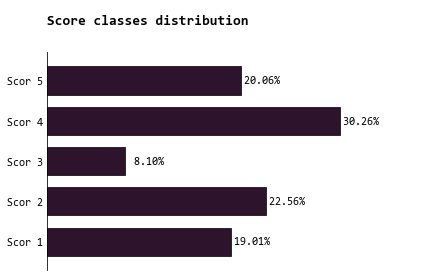

In [91]:
scores = list(range(1, 6))
y_coord = [s/2 for s in scores]
dataset_size = len(housing_data.index)
perc_distribution = [100 * len(housing_data[housing_data['Scor']==s]) / dataset_size
                     for s in scores]

fig = plt.figure(figsize=(7, 4))
ax = plt.axes()
bar_width = .35

bar_perc = ax.barh(y_coord, perc_distribution, height=bar_width,
                  color=plot_colors.dark_2, edgecolor='black', linewidth=.7)

# Adding text representing percentage of data for each class
for s in scores:
  data_perc = '   {:10.2f}'.format(perc_distribution[s-1]) + '% '
  ax.text(perc_distribution[s-1], y_coord[s-1], data_perc,
          horizontalalignment ='center', verticalalignment ='center', 
          fontproperties=text_font)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.set_xlim([0, max(perc_distribution)+10])
ax.set_xticks([])
ax.set_ylim([y_coord[0]-bar_width, y_coord[-1]+bar_width])
ax.set_yticks(y_coord)
ax.set_yticklabels(['Scor ' + str(s) for s in scores], fontproperties=labels_font)
ax.tick_params(axis='y', color='black', length=0, width=0)

ax.set_title('\n\n', fontproperties=title_font, 
             horizontalalignment='center')
title = ax.text(0, y_coord[-1]+.7, 'Score classes distribution',
                fontproperties=title_font)

## **A.** ***Scor*** **Classification**

##Processing data

### **Checking for missing values**

---



Fortunately, this dataset does not contain `null` values.

In [92]:
if housing_data.isnull().values.any():
  print('The dataset contains null values.')
else:
  print('The dataset doesn\'t contain any null values.')

The dataset doesn't contain any null values.


### **Dealing with categorical data**

---  

This dataset contains four columns with discrete/categorical values :  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; ***Nr_Camere***&nbsp; &nbsp; |&nbsp; &nbsp; ***Etaj***&nbsp; &nbsp; |&nbsp; &nbsp; ***Total_Etaje***&nbsp; &nbsp; |&nbsp; &nbsp; ***Sector***


In [93]:
housing_data.head()

,Nr_Camere,Suprafata,Etaj,Total_Etaje,Sector,Scor,Pret
0,4,108.00,2,3,4,5,83000
1,1,41.00,1,8,1,1,39900
2,3,63.52,1,3,2,3,84900
3,1,33.00,3,10,5,1,45500
4,2,62.00,5,9,5,5,54900


Displaying some information about these columns:  

In [94]:
categ_cols = ['Nr_Camere', 'Etaj', 'Total_Etaje', 'Sector']

print_spaces = [len(c) for c in categ_cols]
max_spaces = max(print_spaces)
for col in range(len(categ_cols)):
  print('%15s :  %2d %s  |   %2d .. %2d  |  %s'%
        (categ_cols[col],
         len(set(housing_data[categ_cols[col]])), 'unique values',
         housing_data[categ_cols[col]].min(), housing_data[categ_cols[col]].max(),
         str(list(set(housing_data[categ_cols[col]])))))

      Nr_Camere :   9 unique values  |    1 ..  9  |  [1, 2, 3, 4, 5, 6, 7, 8, 9]
           Etaj :  19 unique values  |   -1 .. 20  |  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 20, -1]
    Total_Etaje :  19 unique values  |    1 .. 24  |  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24]
         Sector :   6 unique values  |    1 ..  6  |  [1, 2, 3, 4, 5, 6]


#### **One-Hot Encoding**

---

The dataset is already declared as a *pandas.DataFrame*, so I'll make use of the *`get_dummies()`* method for encoding the categorical columns, specifying ***float64*** as output type.  
  

Before encoding, we check the type of data in each column and see that there are only ***numerical*** values.

In [95]:
housing_data.dtypes

Nr_Camere        int64
Suprafata      float64
Etaj             int64
Total_Etaje      int64
Sector           int64
Scor             int64
Pret             int64
dtype: object

After encoding, if we check the data again, we notice that the non-categorical columns now contain ***object*** types.  
In order to be able to work with this data, we'll convert them to ***float64*** type.

In [96]:
encoded_housing_data = housing_data.copy()
encoded_housing_data = pd.get_dummies(encoded_housing_data.astype(str), columns=categ_cols, dtype='float64')
encoded_housing_data.dtypes['Suprafata':'Pret']

Suprafata    object
Scor         object
Pret         object
dtype: object

In [97]:
encoded_housing_data['Suprafata'] = encoded_housing_data.Suprafata.astype('float64')
encoded_housing_data['Scor'] = encoded_housing_data.Scor.astype('float64')
encoded_housing_data['Pret'] = encoded_housing_data.Pret.astype('float64')
encoded_housing_data.dtypes['Suprafata':'Pret']

Suprafata    float64
Scor         float64
Pret         float64
dtype: object

Every categorical column has been replaced by a number of new columns equal to the number of unique values in the initial column.  
  
  
So, for example, for the first entry, the initial value **4** corresponding to the feature *`Nr Camere`*, has been encoded as **0** in columns  
*`Nr Camere_1 .. Nr Camere_9`*, except for the column *`Nr Camere_4`*, where we have the value **1**.  
For the second entry, the initial value **1** corresponding to the feature *`Nr Camere`*, has been encoded as **0** in columns  
*`Nr Camere_2 .. Nr Camere_9`* and **1** in the column *`Nr Camere_1`*.

In [98]:
encoded_housing_data.head()

,Suprafata,Scor,Pret,Nr_Camere_1,Nr_Camere_2,Nr_Camere_3,Nr_Camere_4,Nr_Camere_5,Nr_Camere_6,Nr_Camere_7,Nr_Camere_8,Nr_Camere_9,Etaj_-1,Etaj_0,Etaj_1,Etaj_10,Etaj_11,Etaj_12,Etaj_13,Etaj_14,Etaj_15,Etaj_17,Etaj_2,Etaj_20,Etaj_3,Etaj_4,Etaj_5,Etaj_6,Etaj_7,Etaj_8,Etaj_9,Total_Etaje_1,Total_Etaje_10,Total_Etaje_11,Total_Etaje_12,Total_Etaje_13,Total_Etaje_14,Total_Etaje_15,Total_Etaje_16,Total_Etaje_17,Total_Etaje_18,Total_Etaje_2,Total_Etaje_24,Total_Etaje_3,Total_Etaje_4,Total_Etaje_5,Total_Etaje_6,Total_Etaje_7,Total_Etaje_8,Total_Etaje_9,Sector_1,Sector_2,Sector_3,Sector_4,Sector_5,Sector_6
0,108.00,5.0,83000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,41.00,1.0,39900.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,63.52,3.0,84900.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,33.00,1.0,45500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,62.00,5.0,54900.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [99]:
housing_data.loc[0:1, 'Nr_Camere':'Suprafata']

,Nr_Camere,Suprafata
0,4,108.0
1,1,41.0


In [100]:
encoded_housing_data.loc[0:1, 'Nr_Camere_1':'Nr_Camere_9']

,Nr_Camere_1,Nr_Camere_2,Nr_Camere_3,Nr_Camere_4,Nr_Camere_5,Nr_Camere_6,Nr_Camere_7,Nr_Camere_8,Nr_Camere_9
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Normalizing the data**

---

After solving the categorical values problem, we're left with dealing with the values in *`Suprafata`* and *`Pret`* columns.  

Before performing any normalization operation, we must split the housing dataset into *training*, *testing* and *validation* sets.

#### **Train - Test - Validation Split**

---


The ***train set*** will contain 70% of the data, the ***test set*** 15% and the ***validation set*** the remaining 15%.

The *`Scor`* column represents the data to predict, so it is extracted as *label* data.

In [0]:
train_data = encoded_housing_data.sample(frac=0.7, random_state=34)
train_labels = train_data['Scor']

test_val_data = encoded_housing_data.drop(train_data.index)

val_data = test_val_data.sample(frac=0.5, random_state=34)
val_labels = val_data['Scor']

test_data = test_val_data.drop(val_data.index)
test_labels = test_data['Scor']

train_data = train_data.drop(columns=['Scor'])
val_data = val_data.drop(columns=['Scor'])
test_data = test_data.drop(columns=['Scor'])

Some observations about the distribution of the data:

*   The *`Suprafata`* and *`Pret`* features, treated independently,  take values in quite a wide range.  
*   Set side by side, the range of *`Suprafata`* values is at a significantly different scale than the range of *`Pret`* values.  
  
  


    


In [0]:
area_feature_raw = train_data['Suprafata'].copy()
price_feature_raw = train_data['Pret'].copy()

In [103]:
raw_data = pd.DataFrame({'': ['MIN', 'MAX', 'MEAN', 'STD_DEV'], 
                         'Suprafata': [area_feature_raw.min(), area_feature_raw.max(), area_feature_raw.mean(), area_feature_raw.std()],
                         'Pret': [price_feature_raw.min(), price_feature_raw.max(), price_feature_raw.mean(), price_feature_raw.std()]})
raw_data

,,Suprafata,Pret
0,MIN,16.000000,19900.000000
1,MAX,350.000000,495000.000000
2,MEAN,70.080692,98294.463968
3,STD_DEV,29.355722,63164.062543


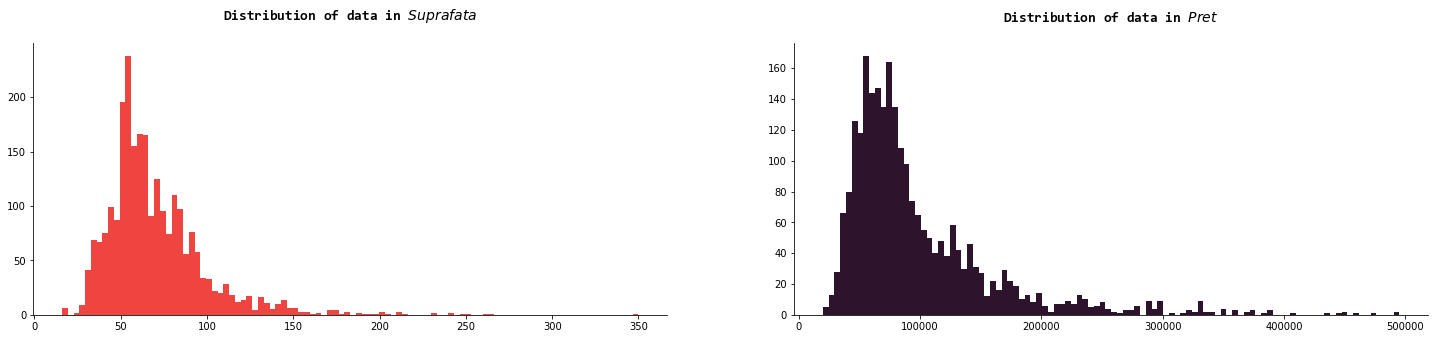

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5), gridspec_kw={'wspace': .2})

comp_area_distr = ax[0].hist(area_feature_raw, bins=100, color=plot_colors.light_2)
comp_price_distr = ax[1].hist(price_feature_raw, bins=100, color=plot_colors.dark_2)

for i in [0, 1]:
  ax[i].spines["top"].set_visible(False)
  ax[i].spines["right"].set_visible(False)

# Adding titles for the subplots
ax[0].set_title('Distribution of data in $\it{Suprafata}$\n', 
                fontproperties=title_font)
ax[1].set_title('Distribution of data in $\it{Pret}$\n', 
                fontproperties=title_font)
plt.box('on')

#### **Zero-mean Centering**

---

Normalizing data using the ***StandardScaler*** from *sklearn* library.  
The scaler is fitted only on training data and then applied on both training and testing data.

In [0]:
scaler = StandardScaler().fit(train_data[['Suprafata', 'Pret']])
train_data[['Suprafata', 'Pret']] = scaler.transform(train_data[['Suprafata', 'Pret']])
val_data[['Suprafata', 'Pret']] = scaler.transform(val_data[['Suprafata', 'Pret']])
test_data[['Suprafata', 'Pret']] = scaler.transform(test_data[['Suprafata', 'Pret']])

Some observations after normalization:  

* The distributions of data is now zero-mean centered
* Each feature now has values in a narrower range
* The two features now have values in much more similar ranges (*the distributions can actually be plotted together*)



In [106]:
area_feature_norm = train_data['Suprafata'].copy()
price_feature_norm = train_data['Pret'].copy()

normalized_data = pd.DataFrame({'': ['MIN', 'MAX', 'MEAN', 'STD_DEV'], 
                         'Suprafata': [area_feature_norm.min(), area_feature_norm.max(), area_feature_norm.mean(), area_feature_norm.std()],
                         'Pret': [price_feature_norm.min(), price_feature_norm.max(), price_feature_norm.mean(), price_feature_norm.std()]})
normalized_data

,,Suprafata,Pret
0,MIN,-1.842627e+00,-1.241376e+00
1,MAX,9.537357e+00,6.281829e+00
2,MEAN,1.943115e-16,1.187534e-16
3,STD_DEV,1.000202e+00,1.000202e+00


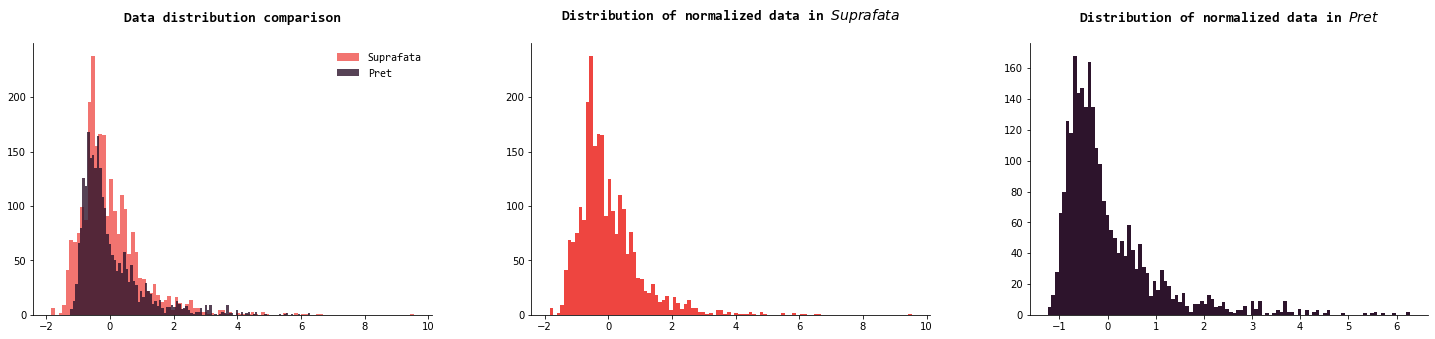

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5), gridspec_kw={'wspace': .25})

comp_area_distr = ax[0].hist(area_feature_norm, bins=100, color=plot_colors.light_2, alpha=.75)
comp_price_distr = ax[0].hist(price_feature_norm, bins=100, color=plot_colors.dark_2, alpha=.8)

area_distr = ax[1].hist(area_feature_norm, bins=100, color=plot_colors.light_2)
price_distr = ax[2].hist(price_feature_norm, bins=100, color=plot_colors.dark_2)

for i in [0, 1, 2]:
  ax[i].spines["top"].set_visible(False)
  ax[i].spines["right"].set_visible(False)

# Adding titles for the subplots
ax[0].set_title('Data distribution comparison\n', 
                fontproperties=title_font)
ax[0].legend(['Suprafata', 'Pret'], loc='upper right', frameon=False, prop=labels_font)

ax[1].set_title('Distribution of normalized data in $\it{Suprafata}$\n', 
                fontproperties=title_font)
ax[2].set_title('Distribution of normalized data in $\it{Pret}$\n', 
                fontproperties=title_font)
plt.box('on')

### **Defining model evaluation representations**

---

Function for visualizing the confusion matrix


In [0]:
def draw_confusion_matrix(conf_matrix, cell_dim, tp_color, fn_color):

  # Convert RGB color to BGR color to use for opencv image
  tp_color = tp_color
  fn_color = fn_color[[2, 1, 0]]
  text_scale = cv.getFontScaleFromHeight(2, cell_dim//4)

  num_labels = conf_matrix.shape[0]
  matrix_img = np.zeros((num_labels*cell_dim, num_labels*cell_dim, 3)).astype('uint8')

  # Get values range for true-positives
  tp_idx = [i for i in range(num_labels)]
  tp_values = conf_matrix[tp_idx, tp_idx]
  min_tp, max_tp = np.min(tp_values), np.max(tp_values)

  # Get values range for false-negatives
  fn_rows = [[i, i, i, i] for i in range(num_labels)]
  fn_cols = [list(range(i)) + list(range(i+1, num_labels)) for i in range(num_labels)]
  fn_values = conf_matrix[fn_rows, fn_cols]
  min_fn, max_fn =  np.min(fn_values), np.max(fn_values)

  # Create the confusion matrix diagonal with true-positives
  for i in range(num_labels):
    intensity = (conf_matrix[i, i]-min_tp) / (max_tp-min_tp) * (-.8) + 1
    cell_color =  tp_color * intensity
    matrix_img[i*cell_dim:(i+1)*cell_dim, i*cell_dim:(i+1)*cell_dim, :] = cell_color.astype('uint8')
    text_pos = (int(i*cell_dim + cell_dim/4), int(i*cell_dim + 5*cell_dim/8))
    cv.putText(matrix_img, str(tp_values[i]), text_pos, 
              fontFace=2, fontScale=text_scale, color=(255, 255, 255))

  # Create the rest of confusion matrix with false-negatives
  for i in range(5):
    for j in range(5):
      if i != j:
        intensity = (conf_matrix[i, j]-min_fn) / (max_fn-min_fn) * (-.8) + 1
        cell_color =  fn_color * intensity
        matrix_img[i*cell_dim:(i+1)*cell_dim, j*cell_dim:(j+1)*cell_dim, :] = cell_color.astype('uint8')
        text_pos = (int(j*cell_dim + cell_dim/4), int(i*cell_dim + 5*cell_dim/8))
        cv.putText(matrix_img, str(conf_matrix[i][j]), text_pos, 
                  fontFace=2, fontScale=text_scale, color=(0, 0, 0))
        
  return matrix_img

### **1. Classification Problem**

#### **Preparing Data for classification**

Converting the data from ***pandas.DataFrame*** format to ***pytorch.Tensor***.  
  
We'll use Cross-Entropy criterion to compute the loss. Hence, the labels tensor must be transformed from range $\small{1\ ..\ 5}$ to range $\small{0\ ..\ 4}$ .

In [0]:
x_train = torch.from_numpy(train_data.values)
y_train = torch.from_numpy(train_labels.values) - 1

x_val = torch.from_numpy(val_data.values)
y_val = torch.from_numpy(val_labels.values) - 1

x_test = torch.from_numpy(test_data.values)
y_test = torch.from_numpy(test_labels.values) - 1

In [0]:
class HousingDataset(Dataset):
  def __init__(self, x_train: torch.Tensor, y_train: torch.Tensor):
    self._x = x_train
    self._y = y_train

  def __len__(self):
    return len(self._x)

  def __getitem__(self, idx):
    return self._x[idx], self._y[idx]

In [0]:
batch_size = 32

housing_dataset = HousingDataset(x_train, y_train)
housing_loader = DataLoader(housing_dataset, batch_size=batch_size, shuffle=True)

#### **Defining the model**

---



*   **Neural network architecture:**  
&nbsp; &nbsp; One hidden layer&nbsp; &nbsp; |&nbsp; &nbsp; Linear transformations&nbsp; &nbsp; |&nbsp; &nbsp; ReLU activation  
  
*   **Loss function:**  
&nbsp; &nbsp; Cross-Entropy  
  
*   **Optimizer:**  
&nbsp; &nbsp; SGD&nbsp; &nbsp; 
  
*   **Regularization:**  
&nbsp; &nbsp; Early stopping&nbsp; &nbsp; |&nbsp; &nbsp; Weight decay

In [0]:
class ClassifierNN1(nn.Module):
  def __init__(self, in_size, hid_size, out_size):
    super().__init__()
    
    self._fc1 = nn.Linear(in_size, hid_size)
    self._fc2 = nn.Linear(hid_size, out_size)
        
  def forward(self, x):
    x = self._fc1(x)
    x = torch.relu(x)
    x = self._fc2(x)

    return x

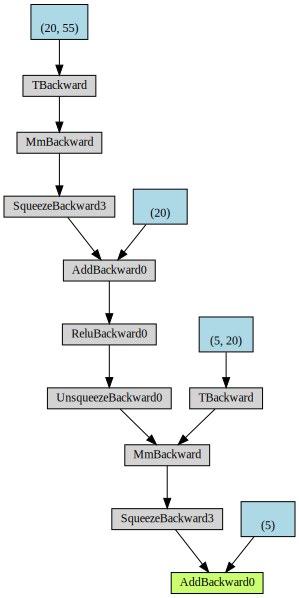

In [113]:
 model_architecture = ClassifierNN1(55, 20, 5)

x = torch.randn(55)
torchviz.make_dot(model_architecture(x))

In [0]:
input_size = 55       # Number of features in the dataset
hidden_size = 25
output_size = 5       # Number of target classes

model1 = ClassifierNN1(input_size, hidden_size, output_size)

**Early stopping condition**

At the end of every epoch, the model is evaluated on a validation set and the current loss value obtained is compared to the previous smallest loss value to decide when to stop training in order to avoid overfitting.  
  
The ***generalization loss*** at current time(epoch) ***t*** is defined as the relative increase of the validation loss considering the lowest validation loss so far:  

$
\hspace{15 mm}
GL_t = \frac{L_{val}(t)}{L_{min}(t)}-1\ ,\ \ \ \ \ \ \ \ \ 
\left.
\begin{array}{ll} 
\small{L_{val}(t) - validation\ loss\ measured\ at\ time\ \bf{t}}\\
\small{L_{val}(t) - smallest\ loss\ value\ measured\ so\ far}\\ 
\end{array}
\right.
$   

$\color{white}{.}$  

---

$\color{white}{.}$
  
The validation loss is fluctuating and is possible to have multiple local minima.  
In order to avoid stopping the training too early and allow the validation loss to get back on a descending slope, we'll add a ***patience*** factor.  
    
This means that after finding an increase in the validation loss, the model is trained for some more epochs and only then, if the validation loss did not decreased, the training is stopped.

In [0]:
patience = 20

# Every time a new minima is found, we save the time, the loss value and the 
# model parameters
checkpoint_epoch = 0
checkpoint_losses = []
checkpoint_path = '/content/checkpointC.pt'

es_epochs = []
es_losses = []
es_models = []

best_loss = np.inf
train_loss = []
validation_loss = []
verbose_step = 50

In [0]:
# After some trials, I found that a learning rate = 0.005 gives the best results
# The regularization parameter is set to 0.001
learning_rate = 0.005
weight_reg = 0.001
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate,
                            weight_decay=weight_reg)

criterion = nn.CrossEntropyLoss()

In [117]:
# We take a counter 'wait' that will monitor the number of epochs trained after
# an increase in the validation loss was found
still_training = True
wait = 0

while still_training:

  iter_loss = []
  for x, y_true in housing_loader:
    x = x.float()
    y_true = y_true.long()

    y_pred = model1(x)
    batch_loss = criterion(y_pred, y_true)

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    iter_loss.append(batch_loss.detach().numpy())

  # At the end of each epoch, we compute the validation loss without 
  # storing it's gradients
  model1.eval()
  with torch.no_grad():
    val_pred = model1(x_val.float())
    val_loss = criterion(val_pred, y_val.long())

  # We compute the generalization loss an compare it to the admissible bound
  es_measure = np.mean(val_loss.detach().numpy()) / best_loss - 1
  if es_measure <= .0002:
    if wait:      
      checkpoint_epoch += wait - 1
      wait = 0

    # The minimum loss found replaces the old one and the current model is saved
    best_loss = np.mean(val_loss.detach().numpy())
    train_loss = train_loss[:checkpoint_epoch]
    validation_loss = validation_loss[:checkpoint_epoch]

    checkpoint_epoch += 1
    checkpoint_losses = [np.mean(iter_loss), np.mean(val_loss.detach().numpy())]
    torch.save(model1.state_dict(), checkpoint_path)
  else:    
    # The loss increased

    if wait == patience:      
      # If we reached the maximum number of extra epochs, the training is stopped
      # The best model is restored
      still_training = False
      model1.load_state_dict(torch.load(checkpoint_path))
      es_epochs.append(checkpoint_epoch)
      es_losses.append(checkpoint_losses)
      es_models.append(model1)

      train_loss = train_loss[:checkpoint_epoch]
      validation_loss = validation_loss[:checkpoint_epoch]

      print('Validation loss not improved for %d epochs since last checkpoint : %.6f ---> %.6f' %
            (patience, best_loss, np.mean(val_loss.detach().numpy())))
      print('Restoring last saved model : epoch %4d' % checkpoint_epoch)
    else:    
      # If we did not reached the maximum number of extra epochs, the training 
      # continues without saving the model
      wait += 1
  
  train_loss.append(np.mean(iter_loss))
  validation_loss.append(np.mean(val_loss.detach().numpy()))

  # Displaying the model's state every 50 epochs
  if (checkpoint_epoch+1+wait) % verbose_step == 0:
      print('EPOCH %4d :' % (checkpoint_epoch+1+wait))
      print('   train_loss = %.6f' % train_loss[-1])
      print('   validation_loss = %.6f' % validation_loss[-1])

EPOCH   50 :
   train_loss = 0.866549
   validation_loss = 0.856931
EPOCH  100 :
   train_loss = 0.659271
   validation_loss = 0.670816
EPOCH  150 :
   train_loss = 0.602800
   validation_loss = 0.611254
EPOCH  200 :
   train_loss = 0.564256
   validation_loss = 0.582806
EPOCH  250 :
   train_loss = 0.545978
   validation_loss = 0.567969
EPOCH  300 :
   train_loss = 0.529453
   validation_loss = 0.558841
EPOCH  300 :
   train_loss = 0.536587
   validation_loss = 0.558610
EPOCH  350 :
   train_loss = 0.516861
   validation_loss = 0.552926
EPOCH  400 :
   train_loss = 0.507899
   validation_loss = 0.548756
EPOCH  400 :
   train_loss = 0.509398
   validation_loss = 0.547980
Validation loss not improved for 20 epochs since last checkpoint : 0.544216 ---> 0.544691
Restoring last saved model : epoch  428


#### **Evaluation of the model**

**Stopping time statistics**

In [118]:
print('TRAINING STOPPED AFTER %4d EPOCHS' % es_epochs[0])
print('%18s : %.5f' % ('Train Loss', es_losses[0][0]))
print('%18s : %.5f' % ('Validation Loss', es_losses[0][1]))

TRAINING STOPPED AFTER  428 EPOCHS
        Train Loss : 0.49878
   Validation Loss : 0.54422


**Visulization of loss improvement**

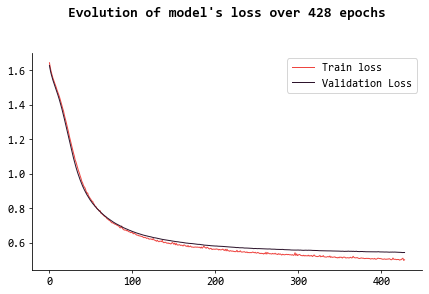

In [119]:
fig = plt.figure(figsize=(7, 4))
ax = plt.axes()

train_plot = ax.plot(train_loss, color=plot_colors.light_2, lw=1)
val_plot = ax.plot(validation_loss, color=plot_colors.dark_2, lw=1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["bottom"].set_visible(False)

ax.set_xticklabels([str(int(tick)) for tick in ax.get_xticks()],
                   fontproperties=labels_font)
ax.set_yticklabels([str('{:1.1f}'.format(tick)) for tick in ax.get_yticks()],
                   fontproperties=labels_font)
ax.tick_params(axis='both', color='black', length=3, width=.75)

legend = ax.legend(['Train loss', 'Validation Loss'], prop=labels_font)
title = ax.set_title('Evolution of model\'s loss over ' + str(es_epochs[0]) +\
                     ' epochs\n\n', 
                     fontproperties=title_font, horizontalalignment='center')

**Model's performance metrics on the training set, the test set and validation set.**

---

The accuracy of classification of the ***training set*** is very close to the accuracy of classification of the ***test set*** and the  
***validation set***. This shows that the model is not overfit.  
  
Also, giving the good scores, the model is not underfit, either.

In [120]:
with torch.no_grad():

    train_output = model1(x_train.float())
    _, train_pred = torch.max(train_output, 1)
    
    validation_output = model1(x_val.float())
    _, validation_pred = torch.max(validation_output, 1)

    test_output = model1(x_test.float())
    _, test_pred = torch.max(test_output, 1)

labels = ['Scor 1', 'Scor 2', 'Scor 3', 'Scor 4', 'Scor 5']

train_report = classification_report(y_train, train_pred, target_names=labels,
                                     output_dict=True)
validation_report = classification_report(y_val, validation_pred, target_names=labels,
                                     output_dict=True)
test_report = classification_report(y_test, test_pred, target_names=labels,
                                     output_dict=True)

table_title = print('Recall score for each class \n'.upper())
header = print('%7s | %10s | %10s | %10s' % (' ', 'Train  ', 'Validation', 'Test   '))
delim = print('-'*48)
for label in labels:
  train_recall = train_report[label]['recall']
  validation_recall = validation_report[label]['recall']
  test_recall = test_report[label]['recall']
  print('%7s | %10.3f | %10.3f | %10.3f' % 
        (label, train_recall, validation_recall, test_recall))

model_score = print('\n\nModel performance'.upper() + ' (f1-score) ')
train_perf = train_report['accuracy']
validation_perf = validation_report['accuracy']
test_perf = test_report['accuracy']
print('%13s : %.2f' % ('Train', train_perf))
print('%13s : %.2f' % ('Validation', validation_perf))
print('%13s : %.2f' % ('Test', test_perf))

RECALL SCORE FOR EACH CLASS 

        |    Train   | Validation |    Test   
------------------------------------------------
 Scor 1 |      0.722 |      0.737 |      0.762
 Scor 2 |      0.607 |      0.542 |      0.434
 Scor 3 |      0.786 |      0.744 |      0.782
 Scor 4 |      0.902 |      0.894 |      0.891
 Scor 5 |      0.868 |      0.828 |      0.750


MODEL PERFORMANCE (f1-score) 
        Train : 0.78
   Validation : 0.76
         Test : 0.73


**Model's performance measured on the validation and test sets**

---

The best results are for data in class *`Scor 4`*, that have the largest number of samples.  
  
Reading the confusion matrix, we notice that most errors are for data in class *`Scor 2`*, that are misclassified as belonging to class *`Scor 1`*.

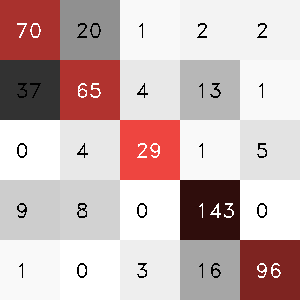

In [121]:
validation_matrix = confusion_matrix(y_val, validation_pred)

tp_color = np.array(img_colors.light_2)[[2, 1, 0]]
fn_color = np.array([255, 255, 255])
confusion_img = draw_confusion_matrix(validation_matrix, 60, tp_color, fn_color)
cv2_imshow(confusion_img)

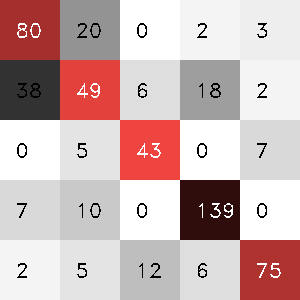

In [122]:
test_matrix = confusion_matrix(y_test, test_pred)

tp_color = np.array(img_colors.light_2)[[2, 1, 0]]
fn_color = np.array([255, 255, 255])
confusion_img = draw_confusion_matrix(test_matrix, 60, tp_color, fn_color)
cv2_imshow(confusion_img)

### **2. Regression Problem**

#### **Preparing Data for regression**

Converting the data from ***pandas.DataFrame*** format to ***pytorch*** format.
  
This time we'll use MSE loss. Hence, the labels tensor will remain in the range $\small{1\ ..\ 5}$.

In [0]:
x_train = torch.from_numpy(train_data.values)
y_train = torch.from_numpy(train_labels.values)

x_val = torch.from_numpy(val_data.values)
y_val = torch.from_numpy(val_labels.values)

x_test = torch.from_numpy(test_data.values)
y_test = torch.from_numpy(test_labels.values)

In [0]:
batch_size = 32

housing_dataset = HousingDataset(x_train, y_train)
housing_loader = DataLoader(housing_dataset, batch_size=batch_size, shuffle=True)

#### **Defining the model**

---



*   **Neural network architecture:**  
&nbsp; &nbsp; One hidden layer&nbsp; &nbsp; |&nbsp; &nbsp; Linear transformations&nbsp; &nbsp; |&nbsp; &nbsp; Custom Sigmoid activation  
  
*   **Loss function:**  
&nbsp; &nbsp; MSE Loss 
  
*   **Optimizer:**  
&nbsp; &nbsp; SGD&nbsp; &nbsp; 
  
*   **Regularization:**  
&nbsp; &nbsp; Early Stopping &nbsp; &nbsp; |&nbsp; &nbsp; Weight decay



---


The regression outputs continuous values.  
In order for the MSE Loss to be meningful in this context, we'll define a custom sigmoid activation:    
$\hspace{10mm}\small{sigmoid\ output\ range}:\ \ [0\ ..\ 1]\hspace{10mm}\rightarrow\hspace{10mm}\small{custom\ sigmoid\ output\ range} :\ [0.5\ ..\ 5.5]$  
  
This way, we discretize the target; every class can be interpreted as continuous values in a range of length $1$:  
$\small{\hspace{5mm}0.5\ ..\ 1.5\hspace{5mm}|\hspace{5mm}1.5\ ..\ 2.5\hspace{5mm}|\hspace{5mm}2.5\ ..\ 3.5\hspace{5mm}|\hspace{5mm}3.5\ ..\ 4.5\hspace{5mm}|\hspace{5mm}4.5\ ..\ 5.5}$  
$\bf{\hspace{12mm}\downarrow \hspace{26mm}\downarrow \hspace{26mm}\downarrow \hspace{26mm}\downarrow \hspace{26mm}\downarrow}$  
$\small{\hspace{7mm}Scor\ 1\hspace{17mm}Scor\ 2\hspace{16mm}Scor\ 3\hspace{16mm}Scor\ 4\hspace{17mm}Scor\ 5}$

In [0]:
def custom_sigmoid(x, new_range):
  score_min, score_max = new_range
  x = torch.sigmoid(x)
  return x * (score_max - score_min) + score_min

In [0]:
class RegressionNN1(nn.Module):
  def __init__(self, in_size, hid_size, out_size, new_range):
    super().__init__()
    self.score_range = new_range
    self._fc1 = nn.Linear(in_size, hid_size)
    self._fc2 = nn.Linear(hid_size, out_size)
        
  def forward(self, x):
    x = self._fc1(x)
    x = torch.relu(x)
    x = self._fc2(x)
    x = custom_sigmoid(x, self.score_range)

    return x

In [0]:
input_size = 55
hidden_size = 25
output_size = 1
score_range = [0.5, 5.5]

In [0]:
patience = 20

# Every time a new minima is found, we save the time, the loss value and the 
# model parameters
checkpoint_epoch = 0
checkpoint_losses = []
checkpoint_path = '/content/checkpointR1.pt'

es_epochs = []
es_losses = []
es_models = []

best_loss = np.inf
train_loss = []
validation_loss = []
log_interval = 25

In [0]:
model2 = RegressionNN1(input_size, hidden_size, output_size, score_range)

learning_rate = 0.005
weight_reg = 0.001
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate,
                            weight_decay=weight_reg)

criterion = nn.MSELoss()

In [130]:
# We take a counter 'wait' that will monitor the number of epochs trained after
# an increase in the validation loss was found
still_training = True
wait = 0

while still_training:

  iter_loss = []
  for x, y_true in housing_loader:
    x = x.float()
    y_pred = model2(x)  
    y_true = y_true.reshape_as(y_pred)
    batch_loss = criterion(y_pred.double(), y_true.double())

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    iter_loss.append(batch_loss.detach().numpy())

  # At the end of each epoch, we compute the validation loss without 
  # storing it's gradients
  model2.eval()
  with torch.no_grad():
    val_pred = model2(x_val.float())
    y_val = y_val.reshape_as(val_pred)
    val_loss = criterion(val_pred.double(), y_val.double())

  # We compute the generalization loss an compare it to the admissible bound
  es_measure = np.mean(val_loss.detach().numpy()) / best_loss - 1
  if es_measure <= .0002:
    if wait:      
      checkpoint_epoch += wait - 1
      wait = 0

    # The minimum loss found replaces the old one and the current model is saved
    best_loss = np.mean(val_loss.detach().numpy())
    train_loss = train_loss[:checkpoint_epoch]
    validation_loss = validation_loss[:checkpoint_epoch]

    checkpoint_epoch += 1
    checkpoint_losses = [np.mean(iter_loss), np.mean(val_loss.detach().numpy())]
    torch.save(model2.state_dict(), checkpoint_path)
  else:    
    # The loss increased

    if wait == patience:      
      # If we reached the maximum number of extra epochs, the training is stopped
      # The best model is restored
      still_training = False
      model2.load_state_dict(torch.load(checkpoint_path))
      es_epochs.append(checkpoint_epoch)
      es_losses.append(checkpoint_losses)
      es_models.append(model2)

      train_loss = train_loss[:checkpoint_epoch]
      validation_loss = validation_loss[:checkpoint_epoch]

      print('Validation loss not improved for %d epochs since last checkpoint : %.6f ---> %.6f' %
            (patience, best_loss, np.mean(val_loss.detach().numpy())))
      print('Restoring last saved model : epoch %4d' % checkpoint_epoch)
    else:    
      # If we did not reached the maximum number of extra epochs, the training 
      # continues without saving the model
      wait += 1
  
  train_loss.append(np.mean(iter_loss))
  validation_loss.append(np.mean(val_loss.detach().numpy()))

  # Displaying the model's state every 50 epochs
  if (checkpoint_epoch+1+wait) % log_interval == 0:
      print('EPOCH %4d :' % (checkpoint_epoch+1+wait))
      print('   train_loss = %.6f' % train_loss[-1])
      print('   validation_loss = %.6f' % validation_loss[-1])

EPOCH   25 :
   train_loss = 0.752092
   validation_loss = 0.702208
EPOCH   25 :
   train_loss = 0.749164
   validation_loss = 0.689634
EPOCH   50 :
   train_loss = 0.669791
   validation_loss = 0.644145
EPOCH   75 :
   train_loss = 0.597542
   validation_loss = 0.612063
EPOCH  100 :
   train_loss = 0.544951
   validation_loss = 0.578985
EPOCH  125 :
   train_loss = 0.522361
   validation_loss = 0.558770
EPOCH  150 :
   train_loss = 0.488916
   validation_loss = 0.543188
EPOCH  175 :
   train_loss = 0.474646
   validation_loss = 0.551745
EPOCH  200 :
   train_loss = 0.459339
   validation_loss = 0.528914
EPOCH  225 :
   train_loss = 0.447451
   validation_loss = 0.521302
EPOCH  250 :
   train_loss = 0.442858
   validation_loss = 0.524830
EPOCH  275 :
   train_loss = 0.442419
   validation_loss = 0.519074
Validation loss not improved for 20 epochs since last checkpoint : 0.512834 ---> 0.513981
Restoring last saved model : epoch  271


#### **Evaluation of the model**

**Stopping time statistics**

In [131]:
print('TRAINING STOPPED AFTER %4d EPOCHS' % es_epochs[0])
print('%18s : %.5f' % ('Train Loss', es_losses[0][0]))
print('%18s : %.5f' % ('Validation Loss', es_losses[0][1]))

TRAINING STOPPED AFTER  271 EPOCHS
        Train Loss : 0.43175
   Validation Loss : 0.51283


**Visulization of loss improvement**

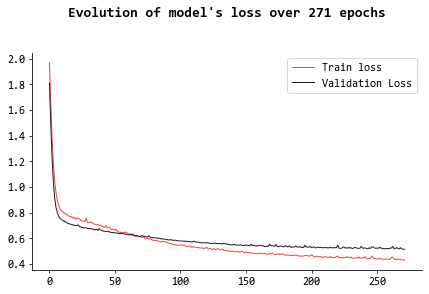

In [132]:
fig = plt.figure(figsize=(7, 4))
ax = plt.axes()

train_plot = ax.plot(train_loss, color=plot_colors.light_2, lw=1)
val_plot = ax.plot(validation_loss, color=plot_colors.dark_2, lw=1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticklabels([str(int(tick)) for tick in ax.get_xticks()],
                   fontproperties=labels_font)
ax.set_yticklabels([str('{:1.1f}'.format(tick)) for tick in ax.get_yticks()],
                   fontproperties=labels_font)
ax.tick_params(axis='both', color='black', length=3, width=.75)

legend = ax.legend(['Train loss', 'Validation Loss'], prop=labels_font)
title = ax.set_title('Evolution of model\'s loss over ' + str(es_epochs[0]) +\
                     ' epochs\n\n', 
                     fontproperties=title_font, horizontalalignment='center')

**Model's performance metrics on the training set, the test set and validation set.**

---



In [133]:
with torch.no_grad():

    train_output = model2(x_train.float()).detach().numpy()
    train_pred = np.rint(train_output)
    for i in range(len(train_pred)):
      train_pred[i] = min(5, train_pred[i])
    
    validation_output = model2(x_val.float()).detach().numpy()
    validation_pred = np.rint(validation_output)
    for i in range(len(validation_pred)):
      validation_pred[i] = min(5, validation_pred[i])

    test_output = model2(x_test.float()).detach().numpy()
    test_pred = np.rint(test_output)
    for i in range(len(test_pred)):
      test_pred[i] = min(5, test_pred[i])

labels = ['Scor 1', 'Scor 2', 'Scor 3', 'Scor 4', 'Scor 5']

train_report = classification_report(y_train, train_pred, target_names=labels,
                                     output_dict=True)
validation_report = classification_report(y_val, validation_pred, target_names=labels,
                                     output_dict=True)
test_report = classification_report(y_test, test_pred, target_names=labels,
                                     output_dict=True)

table_title = print('Recall score for each class \n'.upper())
header = print('%7s | %10s | %10s | %10s' % (' ', 'Train  ', 'Validation', 'Test   '))
delim = print('-'*48)
for label in labels:
  train_recall = train_report[label]['recall']
  validation_recall = validation_report[label]['recall']
  test_recall = test_report[label]['recall']
  print('%7s | %10.3f | %10.3f | %10.3f' % 
        (label, train_recall, validation_recall, test_recall))

model_score = print('\n\nModel performance'.upper() + ' (f1-score) ')
train_perf = train_report['accuracy']
validation_perf = validation_report['accuracy']
test_perf = test_report['accuracy']
print('%13s : %.2f' % ('Train', train_perf))
print('%13s : %.2f' % ('Validation', validation_perf))
print('%13s : %.2f' % ('Test', test_perf))

RECALL SCORE FOR EACH CLASS 

        |    Train   | Validation |    Test   
------------------------------------------------
 Scor 1 |      0.469 |      0.389 |      0.438
 Scor 2 |      0.590 |      0.450 |      0.407
 Scor 3 |      0.578 |      0.590 |      0.527
 Scor 4 |      0.811 |      0.775 |      0.788
 Scor 5 |      0.646 |      0.629 |      0.540


MODEL PERFORMANCE (f1-score) 
        Train : 0.64
   Validation : 0.59
         Test : 0.56


**Model's performance measured on the validation and test sets**

---

The best results are for data in class *`Scor 4`*, that have the largest number of samples.  
  
This time, reading the confusion matrix, we notice that many samples in class *`Scor 1`* are misclassified as belonging to class *`Scor 2`* and many samples in class *`Scor 2`* are misclassified as belonging to class *`Scor 1`*, but also as belonging to class *`Scor 3`*.

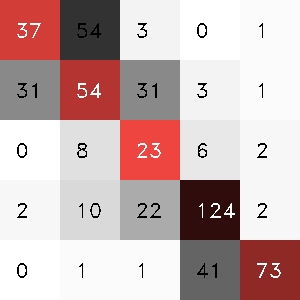

In [134]:
validation_matrix = confusion_matrix(y_val, validation_pred)

tp_color = np.array(img_colors.light_2)[[2, 1, 0]]
fn_color = np.array([255, 255, 255])
confusion_img = draw_confusion_matrix(validation_matrix, 60, tp_color, fn_color)
cv2_imshow(confusion_img)

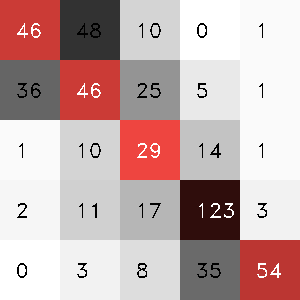

In [135]:
test_matrix = confusion_matrix(y_test, test_pred)

tp_color = np.array(img_colors.light_2)[[2, 1, 0]]
fn_color = np.array([255, 255, 255])
confusion_img = draw_confusion_matrix(test_matrix, 60, tp_color, fn_color)
cv2_imshow(confusion_img)

## **B.** ***Pret*** **Prediction**

##Processing data

### **Dealing with categorical data**

---  

This dataset contains five columns with discrete/categorical values :  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; ***Nr_Camere***&nbsp; &nbsp; |&nbsp; &nbsp; ***Etaj***&nbsp; &nbsp; |&nbsp; &nbsp; ***Total_Etaje***&nbsp; &nbsp; |&nbsp; &nbsp; ***Sector***&nbsp; &nbsp; |&nbsp; &nbsp; ***Scor***


In [136]:
housing_data.head()

,Nr_Camere,Suprafata,Etaj,Total_Etaje,Sector,Scor,Pret
0,4,108.00,2,3,4,5,83000
1,1,41.00,1,8,1,1,39900
2,3,63.52,1,3,2,3,84900
3,1,33.00,3,10,5,1,45500
4,2,62.00,5,9,5,5,54900


Displaying some information about these columns:  

In [137]:
categ_cols = ['Nr_Camere', 'Etaj', 'Total_Etaje', 'Sector', 'Scor']

print_spaces = [len(c) for c in categ_cols]
max_spaces = max(print_spaces)
for col in range(len(categ_cols)):
  print('%15s :  %2d %s  |   %2d .. %2d  |  %s'%
        (categ_cols[col],
         len(set(housing_data[categ_cols[col]])), 'unique values',
         housing_data[categ_cols[col]].min(), housing_data[categ_cols[col]].max(),
         str(list(set(housing_data[categ_cols[col]])))))

      Nr_Camere :   9 unique values  |    1 ..  9  |  [1, 2, 3, 4, 5, 6, 7, 8, 9]
           Etaj :  19 unique values  |   -1 .. 20  |  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 20, -1]
    Total_Etaje :  19 unique values  |    1 .. 24  |  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24]
         Sector :   6 unique values  |    1 ..  6  |  [1, 2, 3, 4, 5, 6]
           Scor :   5 unique values  |    1 ..  5  |  [1, 2, 3, 4, 5]


#### **One-Hot Encoding**

---

The dataset is already declared as a *pandas.DataFrame*, so I'll make use of the *`get_dummies()`* method for encoding the categorical columns, specifying ***float64*** as output type.  
  

Before encoding, we check the type of data in each column and see that there are only ***numerical*** values.

In [138]:
housing_data.dtypes

Nr_Camere        int64
Suprafata      float64
Etaj             int64
Total_Etaje      int64
Sector           int64
Scor             int64
Pret             int64
dtype: object

After encoding, if we check the data again, we notice that the non-categorical columns now contain ***object*** types.  
In order to be able to work with this data, we'll convert them to ***float64*** type.

In [139]:
encoded_housing_data = housing_data.copy()
encoded_housing_data = pd.get_dummies(encoded_housing_data.astype(str), columns=categ_cols, dtype='float64')
encoded_housing_data.dtypes['Suprafata':'Pret']

Suprafata    object
Pret         object
dtype: object

In [140]:
encoded_housing_data['Suprafata'] = encoded_housing_data.Suprafata.astype('float64')
encoded_housing_data['Pret'] = encoded_housing_data.Pret.astype('float64')
encoded_housing_data.dtypes['Suprafata':'Pret']

Suprafata    float64
Pret         float64
dtype: object

Every categorical column has been replaced by a number of new columns equal to the number of unique values in the initial column.  

In [141]:
encoded_housing_data.head()

,Suprafata,Pret,Nr_Camere_1,Nr_Camere_2,Nr_Camere_3,Nr_Camere_4,Nr_Camere_5,Nr_Camere_6,Nr_Camere_7,Nr_Camere_8,Nr_Camere_9,Etaj_-1,Etaj_0,Etaj_1,Etaj_10,Etaj_11,Etaj_12,Etaj_13,Etaj_14,Etaj_15,Etaj_17,Etaj_2,Etaj_20,Etaj_3,Etaj_4,Etaj_5,Etaj_6,Etaj_7,Etaj_8,Etaj_9,Total_Etaje_1,Total_Etaje_10,Total_Etaje_11,Total_Etaje_12,Total_Etaje_13,Total_Etaje_14,Total_Etaje_15,Total_Etaje_16,Total_Etaje_17,Total_Etaje_18,Total_Etaje_2,Total_Etaje_24,Total_Etaje_3,Total_Etaje_4,Total_Etaje_5,Total_Etaje_6,Total_Etaje_7,Total_Etaje_8,Total_Etaje_9,Sector_1,Sector_2,Sector_3,Sector_4,Sector_5,Sector_6,Scor_1,Scor_2,Scor_3,Scor_4,Scor_5
0,108.00,83000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,41.00,39900.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,63.52,84900.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,33.00,45500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,62.00,54900.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### **Normalizing the data**

---

After solving the categorical values problem, we're left with dealing with the values in *`Suprafata`* and *`Pret`* columns.  

Before performing any normalization operation, we must split the housing dataset into *training*, *testing* and *validation* sets.

#### **Train - Test - Validation Split**

---


The ***train set*** will contain 70% of the data, the ***test set*** 15% and the ***validation set*** the remaining 15%.

The *`Pret`* column represents the data to predict, so it is extracted as *label* data.

In [0]:
train_data = encoded_housing_data.sample(frac=0.7, random_state=34)
train_labels = train_data['Pret']

test_val_data = encoded_housing_data.drop(train_data.index)

val_data = test_val_data.sample(frac=0.5, random_state=34)
val_labels = val_data['Pret']

test_data = test_val_data.drop(val_data.index)
test_labels = test_data['Pret']

train_data = train_data.drop(columns=['Pret'])
val_data = val_data.drop(columns=['Pret'])
test_data = test_data.drop(columns=['Pret'])

Some observations about the distribution of the data:

*   The *`Suprafata`* takes values in quite a wide range. 
  
  


    


In [0]:
area_feature_raw = train_data['Suprafata'].copy()

In [144]:
raw_data = pd.DataFrame({'': ['MIN', 'MAX', 'MEAN', 'STD_DEV'], 
                         'Suprafata': [area_feature_raw.min(), area_feature_raw.max(), area_feature_raw.mean(), area_feature_raw.std()]})
raw_data

,,Suprafata
0,MIN,16.000000
1,MAX,350.000000
2,MEAN,70.080692
3,STD_DEV,29.355722


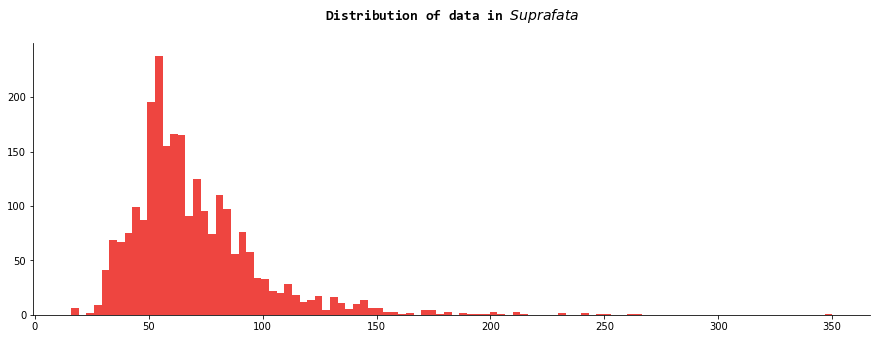

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), gridspec_kw={'wspace': .2})

comp_area_distr = ax.hist(area_feature_raw, bins=100, color=plot_colors.light_2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_title('Distribution of data in $\it{Suprafata}$\n', fontproperties=title_font)

plt.box('on')

#### **Zero-mean Centering**

---

Normalizing data using the ***StandardScaler*** from *sklearn* library.  
The scaler is fitted only on training data and then applied on both training and testing data.

In [0]:
scaler = StandardScaler().fit(train_data[['Suprafata']])
train_data[['Suprafata']] = scaler.transform(train_data[['Suprafata']])
val_data[['Suprafata']] = scaler.transform(val_data[['Suprafata']])
test_data[['Suprafata']] = scaler.transform(test_data[['Suprafata']])

Some observations after normalization:  

* The distributions of data is now zero-mean centered
* The values are now in a narrower range



In [147]:
area_feature_norm = train_data['Suprafata'].copy()

normalized_data = pd.DataFrame({'': ['MIN', 'MAX', 'MEAN', 'STD_DEV'], 
                         'Suprafata': [area_feature_norm.min(), area_feature_norm.max(), area_feature_norm.mean(), area_feature_norm.std()]})
normalized_data

,,Suprafata
0,MIN,-1.842627e+00
1,MAX,9.537357e+00
2,MEAN,1.943115e-16
3,STD_DEV,1.000202e+00


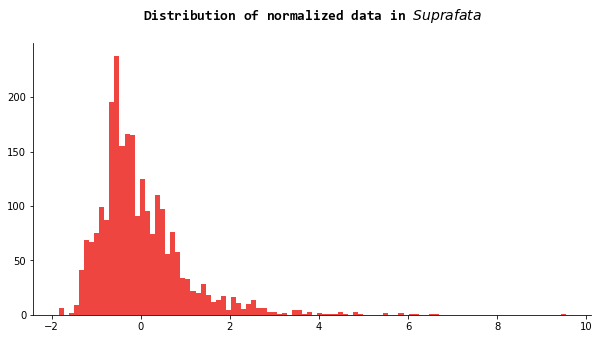

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), gridspec_kw={'wspace': .25})

area_distr = ax.hist(area_feature_norm, bins=100, color=plot_colors.light_2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_title('Distribution of normalized data in $\it{Suprafata}$\n', 
                fontproperties=title_font)

plt.box('on')

#### **Preparing the Data**

Converting the data from ***pandas.DataFrame*** format to ***pytorch.Tensor***. 

In [0]:
x_train = torch.from_numpy(train_data.values)
x_val = torch.from_numpy(val_data.values)
x_test = torch.from_numpy(test_data.values)

After an attempt to train with the **`Pret`** values not normalize, the gradients exploded, even after trying to change the network depth and the learning rate.  
  
Hence, I decided to normalize the **`Pret`** values.

In [0]:
price_scaler = StandardScaler().fit(train_labels.values.reshape(-1, 1))

y_train = price_scaler.transform(train_labels.values.reshape(-1, 1))
y_val = price_scaler.transform(val_labels.values.reshape(-1, 1))
y_test = price_scaler.transform(test_labels.values.reshape(-1, 1))

y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

In [151]:
print('TRAIN SET ')
print('     Data : %s' % list(x_train.shape))
print('   Target : %s' % list(y_train.shape))

print('\nVALIDATION SET ')
print('     Data : %s' % list(x_val.shape))
print('   Target : %s' % list(y_val.shape))

print('\nTEST SET ')
print('     Data : %s' % list(x_test.shape))
print('   Target : %s' % list(y_test.shape))

TRAIN SET 
     Data : [2470, 59]
   Target : [2470, 1]

VALIDATION SET 
     Data : [530, 59]
   Target : [530, 1]

TEST SET 
     Data : [529, 59]
   Target : [529, 1]


In [0]:
class HousingDataset(Dataset):
  def __init__(self, x_train: torch.Tensor, y_train: torch.Tensor):
    self._x = x_train
    self._y = y_train

  def __len__(self):
    return len(self._x)

  def __getitem__(self, idx):
    return self._x[idx], self._y[idx]

In [0]:
batch_size = 32

housing_dataset = HousingDataset(x_train, y_train)
housing_loader = DataLoader(housing_dataset, batch_size=batch_size, shuffle=True)

#### **Defining the model**

---



*   **Neural network architecture:**  
&nbsp; &nbsp; Two hidden layers&nbsp; &nbsp; |&nbsp; &nbsp; Linear transformations&nbsp; &nbsp; |&nbsp; &nbsp; Sigmoid $\small{\text{(gave better results than ReLU)}}$
  
*   **Loss function:**  
&nbsp; &nbsp; MSE Loss 
  
*   **Optimizer:**  
&nbsp; &nbsp; SGD&nbsp; &nbsp; 
  
*   **Regularization:**  
&nbsp; &nbsp; Early Stopping &nbsp; &nbsp; |&nbsp; &nbsp; Weight decay

In [0]:
class RegressionNN2(nn.Module):
  def __init__(self, in_size, hid1_size, hid2_size, out_size):
    super().__init__()
    self._fc1 = nn.Linear(in_size, hid1_size)
    self._fc2 = nn.Linear(hid1_size, hid2_size)
    self._fc3 = nn.Linear(hid2_size, out_size)
        
  def forward(self, x):
    x = self._fc1(x)
    x = torch.sigmoid(x)
    x = self._fc2(x)
    x = torch.sigmoid(x)
    x = self._fc3(x)

    return x

In [0]:
input_size = 59
hidden1_size = 200
hidden2_size = 50
output_size = 1

In [0]:
model3 = RegressionNN2(input_size, hidden1_size, hidden2_size, output_size)

learning_rate = 0.001
weight_reg = 0.01
optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate,
                            weight_decay=weight_reg)

criterion = nn.MSELoss()

In [0]:
patience = 20

# Every time a new minima is found, we save the time, the loss value and the 
# model parameters
checkpoint_epoch = 0
checkpoint_losses = []
checkpoint_path = '/content/checkpointR2.pt'

es_epochs = []
es_losses = []
es_models = []

best_loss = np.inf
train_loss = []
validation_loss = []
log_interval = 25

In [158]:
# We take a counter 'wait' that will monitor the number of epochs trained after
# an increase in the validation loss was found
still_training = True
wait = 0

while still_training:
  iter_loss = []
  for x, y_true in housing_loader:
    x = x.float()
    y_pred = model3(x)  
    y_true = y_true.reshape_as(y_pred)
    batch_loss = criterion(y_pred.double(), y_true.double())

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    iter_loss.append(batch_loss.detach().numpy())

  # At the end of each epoch, we compute the validation loss without 
  # storing it's gradients
  model3.eval()
  with torch.no_grad():
    val_pred = model3(x_val.float())
    y_val = y_val.reshape_as(val_pred)
    val_loss = criterion(val_pred.double(), y_val.double())

  # We compute the generalization loss an compare it to the admissible bound
  es_measure = np.mean(val_loss.detach().numpy()) / best_loss - 1
  if es_measure <= 0.0002:
    if wait:      
      checkpoint_epoch += wait - 1
      wait = 0

    # The minimum loss found replaces the old one and the current model is saved
    best_loss = np.mean(val_loss.detach().numpy())
    train_loss = train_loss[:checkpoint_epoch]
    validation_loss = validation_loss[:checkpoint_epoch]

    checkpoint_epoch += 1
    checkpoint_losses = [np.mean(iter_loss), np.mean(val_loss.detach().numpy())]
    torch.save(model3.state_dict(), checkpoint_path)
  else:    
    # The loss increased

    if wait == patience:      
      # If we reached the maximum number of extra epochs, the training is stopped
      # The best model is restored
      still_training = False
      model3.load_state_dict(torch.load(checkpoint_path))
      es_epochs.append(checkpoint_epoch)
      es_losses.append(checkpoint_losses)
      es_models.append(model3)

      train_loss = train_loss[:checkpoint_epoch]
      validation_loss = validation_loss[:checkpoint_epoch]

      print('Validation loss not improved for %d epochs since last checkpoint : %.6f ---> %.6f' %
            (patience, best_loss, np.mean(val_loss.detach().numpy())))
      print('Restoring last saved model : epoch %4d' % checkpoint_epoch)
    else:    
      # If we did not reached the maximum number of extra epochs, the training 
      # continues without saving the model
      wait += 1
  
  train_loss.append(np.mean(iter_loss))
  validation_loss.append(np.mean(val_loss.detach().numpy()))

  # Displaying the model's state every 50 epochs
  if (checkpoint_epoch+1+wait) % log_interval == 0:
      print('EPOCH %4d :' % (checkpoint_epoch+1+wait))
      print('   train_loss = %.6f' % train_loss[-1])
      print('   validation_loss = %.6f' % np.mean(val_loss.detach().numpy()))

EPOCH   25 :
   train_loss = 0.982442
   validation_loss = 0.968259
EPOCH   50 :
   train_loss = 0.968028
   validation_loss = 0.950994
EPOCH   75 :
   train_loss = 0.944402
   validation_loss = 0.921857
EPOCH   75 :
   train_loss = 0.928954
   validation_loss = 0.918452
EPOCH  100 :
   train_loss = 0.880632
   validation_loss = 0.871773
EPOCH  125 :
   train_loss = 0.795412
   validation_loss = 0.785067
EPOCH  150 :
   train_loss = 0.658845
   validation_loss = 0.635148
EPOCH  175 :
   train_loss = 0.451798
   validation_loss = 0.439082
EPOCH  200 :
   train_loss = 0.320046
   validation_loss = 0.309552
EPOCH  225 :
   train_loss = 0.277311
   validation_loss = 0.265116
EPOCH  225 :
   train_loss = 0.278550
   validation_loss = 0.263838
EPOCH  250 :
   train_loss = 0.261549
   validation_loss = 0.247182
EPOCH  275 :
   train_loss = 0.255070
   validation_loss = 0.239349
EPOCH  275 :
   train_loss = 0.255088
   validation_loss = 0.238959
EPOCH  300 :
   train_loss = 0.248924
   validat

#### **Evaluation of the model**

**Stopping time statistics**

In [159]:
# Computing the test set loss
model3.eval()
with torch.no_grad():
  test_pred = model3(x_test.float())
  y_test = y_test.reshape_as(test_pred)
  test_loss = criterion(test_pred.double(), y_test.double())
  test_loss = np.mean(test_loss.detach().numpy())

print('TRAINING STOPPED AFTER %4d EPOCHS' % es_epochs[0])
print('%18s : %.5f' % ('Train Loss', es_losses[0][0]))
print('%18s : %.5f' % ('Validation Loss', es_losses[0][1]))
print('%18s : %.5f' % ('Test Loss', test_loss))

TRAINING STOPPED AFTER  705 EPOCHS
        Train Loss : 0.23003
   Validation Loss : 0.21284
         Test Loss : 0.23532


**Visulization of loss improvement**

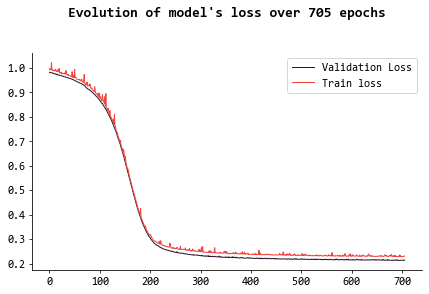

In [160]:
fig = plt.figure(figsize=(7, 4))
ax = plt.axes()

val_plot = ax.plot(validation_loss, color=plot_colors.dark_2, lw=1)
train_plot = ax.plot(train_loss, color=plot_colors.light_2, lw=1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticklabels([str(int(tick)) for tick in ax.get_xticks()],
                   fontproperties=labels_font)
ax.set_yticklabels([str('{:1.1f}'.format(tick)) for tick in ax.get_yticks()],
                   fontproperties=labels_font)
ax.tick_params(axis='both', color='black', length=3, width=.75)

legend = ax.legend(['Validation Loss', 'Train loss'], prop=labels_font)
title = ax.set_title('Evolution of model\'s loss over ' + str(es_epochs[0]) +\
                     ' epochs\n\n', 
                     fontproperties=title_font, horizontalalignment='center')



---


Scaling back the **`Pret`** values.

In [0]:
y_test_back = price_scaler.inverse_transform(y_test)[:, 0]
pred_test_back = price_scaler.inverse_transform(test_pred)[:, 0]

In [166]:
print('     True Pret values range : %7.2f .. %7.2f' % 
      (np.min(np.array(y_test_back)), np.max(np.array(y_test_back))))
print('Predicted Pret values range : %7.2f .. %7.2f' % 
      (np.min(np.array(pred_test_back)), np.max(np.array(pred_test_back))))

     True Pret values range : 19500.00 .. 450000.00
Predicted Pret values range : 21270.46 .. 317375.03




---

We notice that the range the predicted values are in is narrower than the one of the true values :  
* The small true values were predicted larger   
* The large true values were predicted smaller

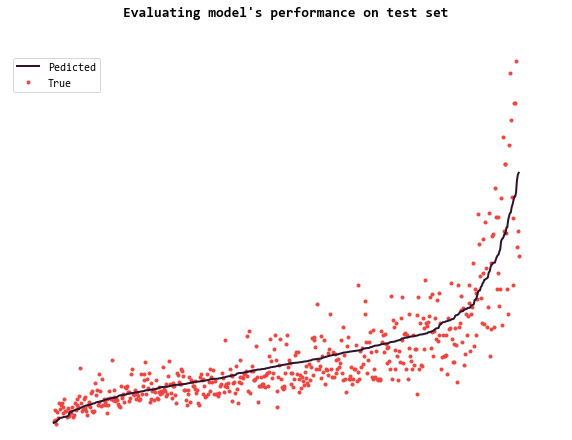

In [185]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

sorted_idx = np.argsort(pred_test_back)
pred_test_back = pred_test_back[sorted_idx]
y_test_back = y_test_back[sorted_idx]
x_coord = np.linspace(0, 1, len(y_test_back))

for p in range(len(y_test_back)):
  mark, = ax.plot(x_coord[p], y_test_back[p], color='white',
                      marker='.',markersize=6, markerfacecolor=plot_colors.light_2, 
                      markeredgecolor=plot_colors.light_2)
  
fit, = ax.plot(x_coord, pred_test_back, color=plot_colors.dark_2, lw=2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.set_xlim([-.1, 1.1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim([np.min(y_test_back)-10000, np.max(y_test_back)+10000])

legend = ax.legend([fit, mark], ['Pedicted', 'True'], prop=labels_font)
title = ax.set_title('Evaluating model\'s performance on test set' + '\n\n', 
                     fontproperties=title_font, horizontalalignment='center')